### Importing Necessary Libraries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import joblib

### Data Loading and Basic EDA

In [2]:
df = pd.read_csv('data/emotions.csv')

In [3]:
display(df.head())

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [6]:
label_counts = df['label'].value_counts().sort_index()
print(label_counts)

label
0    121187
1    141067
2     34554
3     57317
4     47712
5     14972
Name: count, dtype: int64


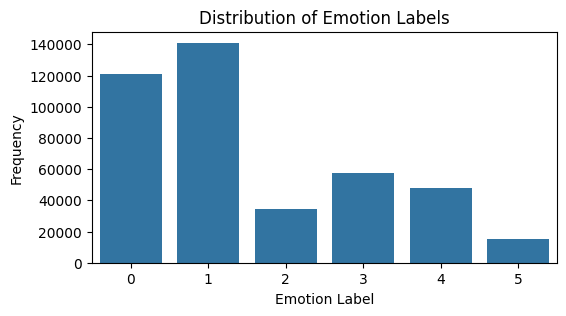

In [7]:
plt.figure(figsize=(6, 3))
sns.countplot(x='label', data=df, order=label_counts.index) 
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion Label')
plt.ylabel('Frequency')
plt.show()

There is imbalance in the dataset. This may affect model and make it biased. Since the test set should have the natural imbalanced dataset, This imbalance can be dealt with later during train test split 

#### Inspecting Sample Texts from each label 

In [8]:
sample_texts_label_0 = df[df['label'] == 0]['text'].sample(3, random_state=42)
for i, text in enumerate(sample_texts_label_0):
        print(f"{i+1}. {text}")

1. ive learned to surround myself with women who lift me up and leave me feeling nurtured rather than drained
2. i already feel crappy because of this and you being upset at me or the situation doesnt help
3. i feel like i have lost mourned and moved past the tears in this relationship


In [9]:
sample_texts_label_1 = df[df['label'] == 1]['text'].sample(3, random_state=42)
for i, text in enumerate(sample_texts_label_1):
        print(f"{i+1}. {text}")

1. i made nico promise to run away screaming if i ever mention floating the dirty devil at anything less than cfs again although i feel it would be safe at cfs or so and i have floated it at a steady cfs without much problem
2. i want to feel as carefree as i did back then
3. i often feel i want to do what i can to cure these many talented and lovely authors spot readers on their books


In [10]:
sample_texts_label_3 = df[df['label'] == 3]['text'].sample(3, random_state=42)
for i, text in enumerate(sample_texts_label_3):
        print(f"{i+1}. {text}")

1. i feel rebellious and i like it
2. i feel completely agitated and full of blame
3. i feel like a witch bc im aggravated and i want to go over there but like i dunno


In [11]:
sample_texts_label_4 = df[df['label'] == 4]['text'].sample(3, random_state=42)
for i, text in enumerate(sample_texts_label_4):
        print(f"{i+1}. {text}")

1. i feel that it creates a suspicious environment where every american is suspect who doesnt goose step to the majority party in power
2. i feel reluctant asking for anything
3. i am afraid to really show what i feel because im terrified of having it thrown back in my face


In [12]:
sample_texts_label_5 = df[df['label'] == 5]['text'].sample(3, random_state=42)
for i, text in enumerate(sample_texts_label_5):
        print(f"{i+1}. {text}")

1. i feel like im advertising here but i was seriously impressed
2. i feel you will be impressed with the entire interview through
3. i still feel a bit funny


#### dictionary to keep track labels 

In [13]:
emotion_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

### Preprocessing

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [15]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove user @mentions
    text = re.sub(r'\@\w+', '', text)
    
    # 4. Remove hashtags
    text = re.sub(r'#', '', text) 
    
    # 5. Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text) 

    # 6. Tokenization 
    tokens = word_tokenize(text)
    
    # 7. Remove stopwords and lemmatize
    processed_tokens = []
    for word in tokens:
        if word not in stop_words: 
            lemma = lemmatizer.lemmatize(word) 
            processed_tokens.append(lemma)
    
    # Join the processed tokens back into a single string
    return " ".join(processed_tokens)


#### preprocessing function test

In [16]:
sample_texts_for_testing = [
    "I am SO HAPPY today, can't believe it! #Blessed http://example.com @user123",
    "Feeling a bit down and weary... watching the news doesn't help.",
    "This is the 3rd time I'm trying this, it's so frustrating!!!"
]

for text_sample in sample_texts_for_testing: 
    print(f"Original: {text_sample}")
    print(f"Processed: {preprocess_text(text_sample)}\n")

Original: I am SO HAPPY today, can't believe it! #Blessed http://example.com @user123
Processed: happy today cant believe blessed

Original: Feeling a bit down and weary... watching the news doesn't help.
Processed: feeling bit weary watching news doesnt help

Original: This is the 3rd time I'm trying this, it's so frustrating!!!
Processed: 3rd time im trying frustrating



#### Preprocessing the Entire Dataset

In [17]:
df['cleaned_text'] = df['text'].apply(preprocess_text)


In [18]:
print(df[['text', 'cleaned_text', 'label']].head())

                                                text  \
0      i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax a...   
2  i gave up my internship with the dmrg and am f...   
3                         i dont know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                        cleaned_text  label  
0                 feel really helpless heavy hearted      4  
1  ive enjoyed able slouch relax unwind frankly n...      0  
2            gave internship dmrg feeling distraught      4  
3                                dont know feel lost      0  
4  kindergarten teacher thoroughly weary job take...      4  


In [19]:
#Check for any empty strings in 'cleaned_text'
empty_string_count = len(df[df['cleaned_text'] == ''])
print(f"\nNumber of empty strings in 'cleaned_text':{empty_string_count}")


Number of empty strings in 'cleaned_text':16


In [20]:
 df = df[df['cleaned_text'] != '']  #remove rows with empty cleaned_text

In [21]:
empty_string_count = len(df[df['cleaned_text'] == ''])
print(f"\nNumber of empty strings in 'cleaned_text':{empty_string_count}")


Number of empty strings in 'cleaned_text':0


#### saving the cleaned dataset

In [22]:
df.to_csv('data/emotions_cleaned.csv', index=False)

#### Reducing dataset size

In [23]:
desired_fraction = 0.25 # Use 25% of the data

In [24]:
df_subset, _ = train_test_split(
    df,
    train_size=desired_fraction, 
    random_state=42,             
    stratify=df['label']    # for maintaining class proportions
)

print(f"Original dataset size: {len(df)}")
print(f"Reduced dataset size (df_subset): {len(df_subset)}")
print("\nOriginal label distribution (normalized):")
print(df['label'].value_counts(normalize=True).sort_index())
print("\nSubset label distribution (normalized):")
print(df_subset['label'].value_counts(normalize=True).sort_index())

Original dataset size: 416793
Reduced dataset size (df_subset): 104198

Original label distribution (normalized):
label
0    0.290751
1    0.338451
2    0.082904
3    0.137505
4    0.114467
5    0.035922
Name: proportion, dtype: float64

Subset label distribution (normalized):
label
0    0.290754
1    0.338452
2    0.082900
3    0.137507
4    0.114465
5    0.035922
Name: proportion, dtype: float64


#### Data Splitting

In [25]:
X = df_subset['cleaned_text'].astype(str) # Ensure it's string type
y = df_subset['label'] 


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### TFIDF Vectorization

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [28]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

X_train_tfidf shape: (83358, 5000)
X_test_tfidf shape: (20840, 5000)


### Model Development

#### Base line Model : Logistic Regression

class_weight is set balanced to deal with the class imbalance found during eda

In [30]:
log_reg_model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=42, class_weight='balanced', max_iter=1000)

In [31]:
log_reg_model.fit(X_train_tfidf, y_train)

/Users/voyager/miniconda3/envs/envcodespace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/voyager/miniconda3/envs/envcodespace/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga')

In [32]:
# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)


In [33]:
#base line model evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg, target_names=[emotion_mapping[i] for i in sorted(y_test.unique())]))

Accuracy: 0.9090
              precision    recall  f1-score   support

     sadness       0.97      0.93      0.95      6059
         joy       0.98      0.88      0.93      7053
        love       0.74      0.97      0.84      1728
       anger       0.90      0.92      0.91      2866
        fear       0.83      0.90      0.87      2385
    surprise       0.70      0.88      0.78       749

    accuracy                           0.91     20840
   macro avg       0.85      0.91      0.88     20840
weighted avg       0.92      0.91      0.91     20840



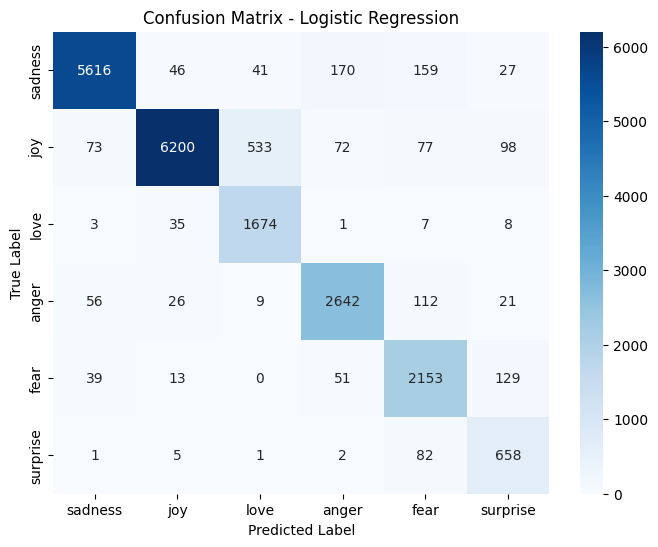

In [34]:
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[emotion_mapping[i] for i in sorted(y_test.unique())], 
            yticklabels=[emotion_mapping[i] for i in sorted(y_test.unique())])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### Main Model - SVM 

#### SVM Kernel Comparison

Training SVM (linear)...
SVM (linear) training complete.
Accuracy: 0.9037

Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.92      0.94      6059
         joy       0.98      0.87      0.92      7053
        love       0.72      0.98      0.83      1728
       anger       0.90      0.92      0.91      2866
        fear       0.85      0.88      0.87      2385
    surprise       0.66      0.93      0.77       749

    accuracy                           0.90     20840
   macro avg       0.85      0.92      0.87     20840
weighted avg       0.92      0.90      0.91     20840


Confusion Matrix:


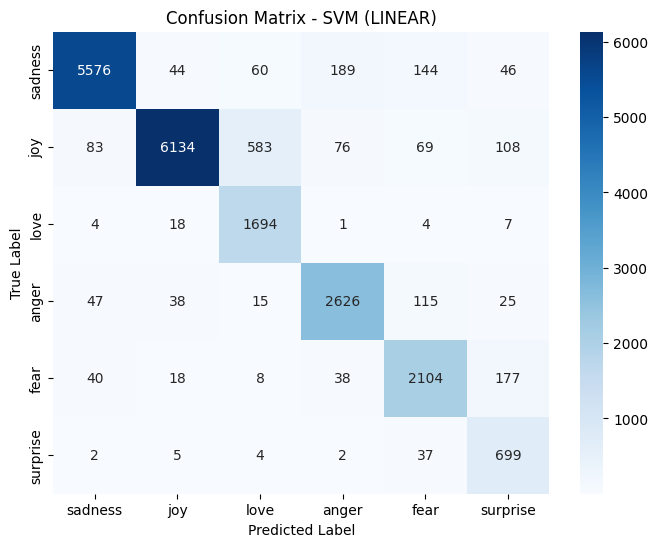

Training SVM (rbf)...
SVM (rbf) training complete.
Accuracy: 0.9035

Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.92      0.94      6059
         joy       0.97      0.88      0.92      7053
        love       0.73      0.96      0.83      1728
       anger       0.90      0.91      0.91      2866
        fear       0.85      0.88      0.86      2385
    surprise       0.69      0.86      0.76       749

    accuracy                           0.90     20840
   macro avg       0.85      0.90      0.87     20840
weighted avg       0.91      0.90      0.91     20840


Confusion Matrix:


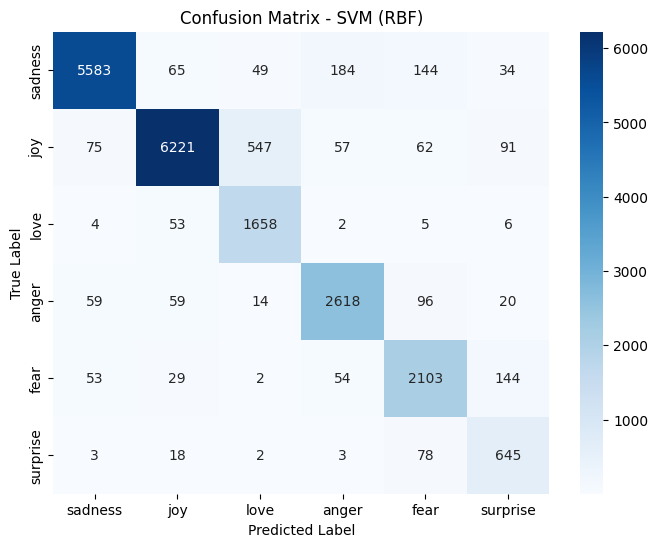

Training SVM (poly)...
SVM (poly) training complete.
Accuracy: 0.7949

Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.88      0.89      6059
         joy       0.70      0.95      0.80      7053
        love       0.77      0.50      0.61      1728
       anger       0.93      0.68      0.79      2866
        fear       0.86      0.62      0.72      2385
    surprise       0.74      0.39      0.51       749

    accuracy                           0.79     20840
   macro avg       0.81      0.67      0.72     20840
weighted avg       0.81      0.79      0.79     20840


Confusion Matrix:


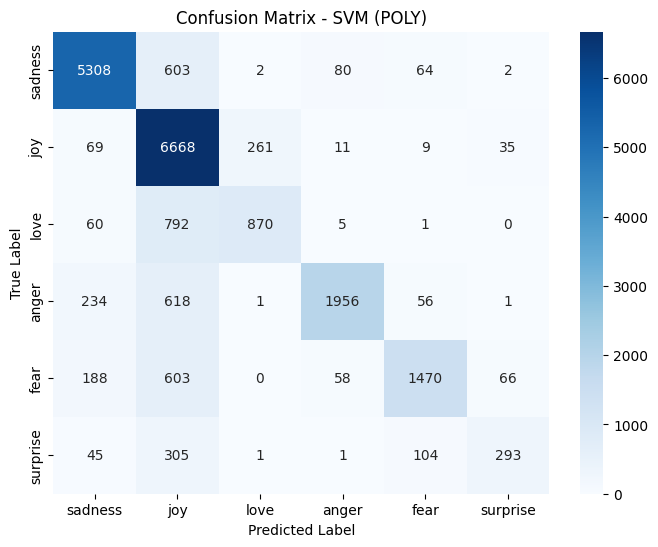

In [35]:
kernels_to_test = ['linear', 'rbf','poly']
svm_results = {}
for kernel_name in kernels_to_test:
    svm_model = SVC(kernel=kernel_name, random_state=42, class_weight='balanced', C=1.0) # Default C=1.0
    print(f"Training SVM ({kernel_name})...")
    svm_model.fit(X_train_tfidf, y_train)
    print(f"SVM ({kernel_name}) training complete.")
   
    # Make predictions
    y_pred_svm = svm_model.predict(X_test_tfidf)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_svm)
    report = classification_report(y_test, y_pred_svm, target_names=[emotion_mapping[i] for i in sorted(y_test.unique())])

    svm_results[kernel_name] = {'accuracy': accuracy, 'report': report, 'model': svm_model}

    print(f"Accuracy: {accuracy:.4f}")  
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[emotion_mapping[i] for i in sorted(y_test.unique())], 
                yticklabels=[emotion_mapping[i] for i in sorted(y_test.unique())])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - SVM ({kernel_name.upper()})')
    plt.show()

In [36]:
for kernel, result in svm_results.items():
    print(f"SVM with {kernel} kernel - Accuracy: {result['accuracy']:.4f}")

SVM with linear kernel - Accuracy: 0.9037
SVM with rbf kernel - Accuracy: 0.9035
SVM with poly kernel - Accuracy: 0.7949


we can chose any of the rbf or linear kernels as they have accuracy above 90 percent

### Exporting Models

In [40]:
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.joblib')

['models/tfidf_vectorizer.joblib']

In [42]:
chosen_kernel_to_save = 'rbf'
model_to_save = svm_results[chosen_kernel_to_save]['model']
model_filename = f'models/svm_model_{chosen_kernel_to_save}.joblib'
joblib.dump(model_to_save, model_filename)

['models/svm_model_rbf.joblib']

In [45]:
chosen_kernel_to_save = 'linear'
model_to_save = svm_results[chosen_kernel_to_save]['model']
model_filename = f'models/svm_model_{chosen_kernel_to_save}.joblib'
joblib.dump(model_to_save, model_filename)

['models/svm_model_linear.joblib']

In [43]:
 model_filename_lr = 'models/logistic_regression_model.joblib'
joblib.dump(log_reg_model, model_filename_lr)

['models/logistic_regression_model.joblib']